# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4530176/11490434 [==========>...................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:41 - loss: 0.6956

  34/1875 [..............................] - ETA: 2s - loss: 0.5289   

  66/1875 [>.............................] - ETA: 2s - loss: 0.4536

  97/1875 [>.............................] - ETA: 2s - loss: 0.4150

 129/1875 [=>............................] - ETA: 2s - loss: 0.3891

 163/1875 [=>............................] - ETA: 2s - loss: 0.3694

 196/1875 [==>...........................] - ETA: 2s - loss: 0.3545

 228/1875 [==>...........................] - ETA: 2s - loss: 0.3426

 262/1875 [===>..........................] - ETA: 2s - loss: 0.3319

 296/1875 [===>..........................] - ETA: 2s - loss: 0.3226

 330/1875 [====>.........................] - ETA: 2s - loss: 0.3145

 364/1875 [====>.........................] - ETA: 2s - loss: 0.3073

 396/1875 [=====>........................] - ETA: 2s - loss: 0.3012

 424/1875 [=====>........................] - ETA: 2s - loss: 0.2963

 457/1875 [======>.......................] - ETA: 2s - loss: 0.2910

 495/1875 [======>.......................] - ETA: 2s - loss: 0.2854

 532/1875 [=======>......................] - ETA: 2s - loss: 0.2804

 570/1875 [========>.....................] - ETA: 1s - loss: 0.2757

 605/1875 [========>.....................] - ETA: 1s - loss: 0.2716

 637/1875 [=========>....................] - ETA: 1s - loss: 0.2682

 669/1875 [=========>....................] - ETA: 1s - loss: 0.2649

 702/1875 [==========>...................] - ETA: 1s - loss: 0.2618

 735/1875 [==========>...................] - ETA: 1s - loss: 0.2588

 769/1875 [===========>..................] - ETA: 1s - loss: 0.2558

 802/1875 [===========>..................] - ETA: 1s - loss: 0.2531

 836/1875 [============>.................] - ETA: 1s - loss: 0.2505

 869/1875 [============>.................] - ETA: 1s - loss: 0.2480

 902/1875 [=============>................] - ETA: 1s - loss: 0.2457

 936/1875 [=============>................] - ETA: 1s - loss: 0.2434

 969/1875 [==============>...............] - ETA: 1s - loss: 0.2412

1001/1875 [===============>..............] - ETA: 1s - loss: 0.2392

1034/1875 [===============>..............] - ETA: 1s - loss: 0.2372

1067/1875 [================>.............] - ETA: 1s - loss: 0.2353

1101/1875 [================>.............] - ETA: 1s - loss: 0.2334

1135/1875 [=================>............] - ETA: 1s - loss: 0.2316

1167/1875 [=================>............] - ETA: 1s - loss: 0.2300

1200/1875 [==================>...........] - ETA: 1s - loss: 0.2283

1233/1875 [==================>...........] - ETA: 0s - loss: 0.2267

1266/1875 [===================>..........] - ETA: 0s - loss: 0.2252

1298/1875 [===================>..........] - ETA: 0s - loss: 0.2237

1330/1875 [====================>.........] - ETA: 0s - loss: 0.2223

1363/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1396/1875 [=====================>........] - ETA: 0s - loss: 0.2195

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2170

1491/1875 [======================>.......] - ETA: 0s - loss: 0.2158

1524/1875 [=======================>......] - ETA: 0s - loss: 0.2146

1556/1875 [=======================>......] - ETA: 0s - loss: 0.2134

1589/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1622/1875 [========================>.....] - ETA: 0s - loss: 0.2111

1656/1875 [=========================>....] - ETA: 0s - loss: 0.2100

1690/1875 [==========================>...] - ETA: 0s - loss: 0.2088

1724/1875 [==========================>...] - ETA: 0s - loss: 0.2078

1759/1875 [===========================>..] - ETA: 0s - loss: 0.2067

1793/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1826/1875 [============================>.] - ETA: 0s - loss: 0.2047

1861/1875 [============================>.] - ETA: 0s - loss: 0.2036

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2032


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1126

  35/1875 [..............................] - ETA: 2s - loss: 0.1084

  69/1875 [>.............................] - ETA: 2s - loss: 0.1088

 103/1875 [>.............................] - ETA: 2s - loss: 0.1089

 136/1875 [=>............................] - ETA: 2s - loss: 0.1089

 170/1875 [=>............................] - ETA: 2s - loss: 0.1088

 205/1875 [==>...........................] - ETA: 2s - loss: 0.1087

 239/1875 [==>...........................] - ETA: 2s - loss: 0.1086

 272/1875 [===>..........................] - ETA: 2s - loss: 0.1085

 307/1875 [===>..........................] - ETA: 2s - loss: 0.1084

 340/1875 [====>.........................] - ETA: 2s - loss: 0.1083

 374/1875 [====>.........................] - ETA: 2s - loss: 0.1083

 405/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 435/1875 [=====>........................] - ETA: 2s - loss: 0.1081

 469/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 503/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 534/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 594/1875 [========>.....................] - ETA: 1s - loss: 0.1077

 625/1875 [=========>....................] - ETA: 1s - loss: 0.1077

 653/1875 [=========>....................] - ETA: 1s - loss: 0.1076

 684/1875 [=========>....................] - ETA: 1s - loss: 0.1075

 720/1875 [==========>...................] - ETA: 1s - loss: 0.1075

 756/1875 [===========>..................] - ETA: 1s - loss: 0.1074

 791/1875 [===========>..................] - ETA: 1s - loss: 0.1073

 825/1875 [============>.................] - ETA: 1s - loss: 0.1072

 861/1875 [============>.................] - ETA: 1s - loss: 0.1072

 896/1875 [=============>................] - ETA: 1s - loss: 0.1071

 932/1875 [=============>................] - ETA: 1s - loss: 0.1070

 969/1875 [==============>...............] - ETA: 1s - loss: 0.1069

1005/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1040/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1077/1875 [================>.............] - ETA: 1s - loss: 0.1067

1112/1875 [================>.............] - ETA: 1s - loss: 0.1066

1148/1875 [=================>............] - ETA: 1s - loss: 0.1065

1186/1875 [=================>............] - ETA: 1s - loss: 0.1064

1220/1875 [==================>...........] - ETA: 0s - loss: 0.1064

1257/1875 [===================>..........] - ETA: 0s - loss: 0.1063

1294/1875 [===================>..........] - ETA: 0s - loss: 0.1062

1326/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1356/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1391/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1427/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1496/1875 [======================>.......] - ETA: 0s - loss: 0.1058

1531/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1605/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1641/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1677/1875 [=========================>....] - ETA: 0s - loss: 0.1055

1707/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1741/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1773/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1808/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1844/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1052


Epoch 3/5


   1/1875 [..............................] - ETA: 3s - loss: 0.0983

  38/1875 [..............................] - ETA: 2s - loss: 0.0995

  73/1875 [>.............................] - ETA: 2s - loss: 0.0989

 105/1875 [>.............................] - ETA: 2s - loss: 0.0987

 136/1875 [=>............................] - ETA: 2s - loss: 0.0987

 165/1875 [=>............................] - ETA: 2s - loss: 0.0987

 196/1875 [==>...........................] - ETA: 2s - loss: 0.0988

 223/1875 [==>...........................] - ETA: 2s - loss: 0.0988

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0988

 287/1875 [===>..........................] - ETA: 2s - loss: 0.0987

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0987

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0987

 381/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0986

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 640/1875 [=========>....................] - ETA: 1s - loss: 0.0984

 672/1875 [=========>....................] - ETA: 1s - loss: 0.0984

 705/1875 [==========>...................] - ETA: 1s - loss: 0.0983

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0983

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0983

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0983

 839/1875 [============>.................] - ETA: 1s - loss: 0.0982

 874/1875 [============>.................] - ETA: 1s - loss: 0.0982

 908/1875 [=============>................] - ETA: 1s - loss: 0.0982

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1084/1875 [================>.............] - ETA: 1s - loss: 0.0981

1116/1875 [================>.............] - ETA: 1s - loss: 0.0981

1148/1875 [=================>............] - ETA: 1s - loss: 0.0981

1181/1875 [=================>............] - ETA: 1s - loss: 0.0981

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1252/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1287/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1320/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1352/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1385/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1821/1875 [============================>.] - ETA: 0s - loss: 0.0978

1853/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1007

  35/1875 [..............................] - ETA: 2s - loss: 0.0945

  68/1875 [>.............................] - ETA: 2s - loss: 0.0946

 104/1875 [>.............................] - ETA: 2s - loss: 0.0950

 136/1875 [=>............................] - ETA: 2s - loss: 0.0952

 169/1875 [=>............................] - ETA: 2s - loss: 0.0954

 202/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 269/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 303/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 338/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 506/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 575/1875 [========>.....................] - ETA: 1s - loss: 0.0960

 608/1875 [========>.....................] - ETA: 1s - loss: 0.0960

 640/1875 [=========>....................] - ETA: 1s - loss: 0.0960

 665/1875 [=========>....................] - ETA: 1s - loss: 0.0960

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0960

 722/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 757/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 785/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 820/1875 [============>.................] - ETA: 1s - loss: 0.0961

 847/1875 [============>.................] - ETA: 1s - loss: 0.0961

 875/1875 [=============>................] - ETA: 1s - loss: 0.0961

 905/1875 [=============>................] - ETA: 1s - loss: 0.0961

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1089/1875 [================>.............] - ETA: 1s - loss: 0.0962

1123/1875 [================>.............] - ETA: 1s - loss: 0.0962

1157/1875 [=================>............] - ETA: 1s - loss: 0.0962

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1256/1875 [===================>..........] - ETA: 0s - loss: 0.0962

1291/1875 [===================>..........] - ETA: 0s - loss: 0.0962

1327/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1363/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1825/1875 [============================>.] - ETA: 0s - loss: 0.0961

1860/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0999

  33/1875 [..............................] - ETA: 2s - loss: 0.0961

  66/1875 [>.............................] - ETA: 2s - loss: 0.0960

  99/1875 [>.............................] - ETA: 2s - loss: 0.0961

 131/1875 [=>............................] - ETA: 2s - loss: 0.0961

 166/1875 [=>............................] - ETA: 2s - loss: 0.0961

 199/1875 [==>...........................] - ETA: 2s - loss: 0.0960

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0960

 267/1875 [===>..........................] - ETA: 2s - loss: 0.0960

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0960

 334/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 594/1875 [========>.....................] - ETA: 1s - loss: 0.0958

 626/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 658/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 689/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 720/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 750/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 781/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 844/1875 [============>.................] - ETA: 1s - loss: 0.0957

 876/1875 [=============>................] - ETA: 1s - loss: 0.0956

 907/1875 [=============>................] - ETA: 1s - loss: 0.0956

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1004/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1069/1875 [================>.............] - ETA: 1s - loss: 0.0956

1101/1875 [================>.............] - ETA: 1s - loss: 0.0956

1133/1875 [=================>............] - ETA: 1s - loss: 0.0956

1166/1875 [=================>............] - ETA: 1s - loss: 0.0956

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1260/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1291/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1322/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1489/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1542/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1814/1875 [============================>.] - ETA: 0s - loss: 0.0955

1848/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

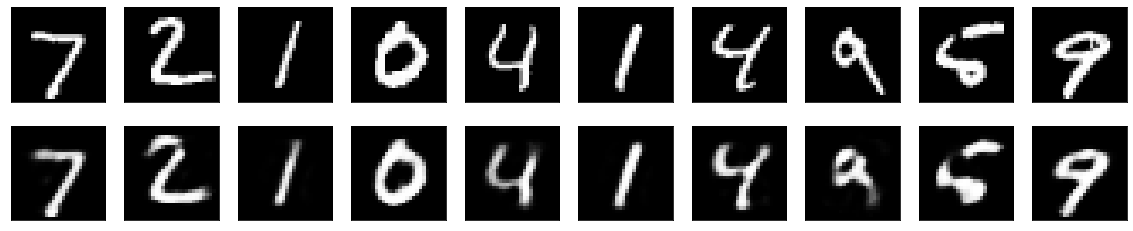

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
